In [294]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [295]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.utils import define_device
import pandas as pd
import numpy as np
np.random.seed(0)
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
import seaborn as sns
import os

from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [296]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [297]:
train = pd.read_csv('/content/drive/MyDrive/CSV/Training_Hi_Scan.csv')

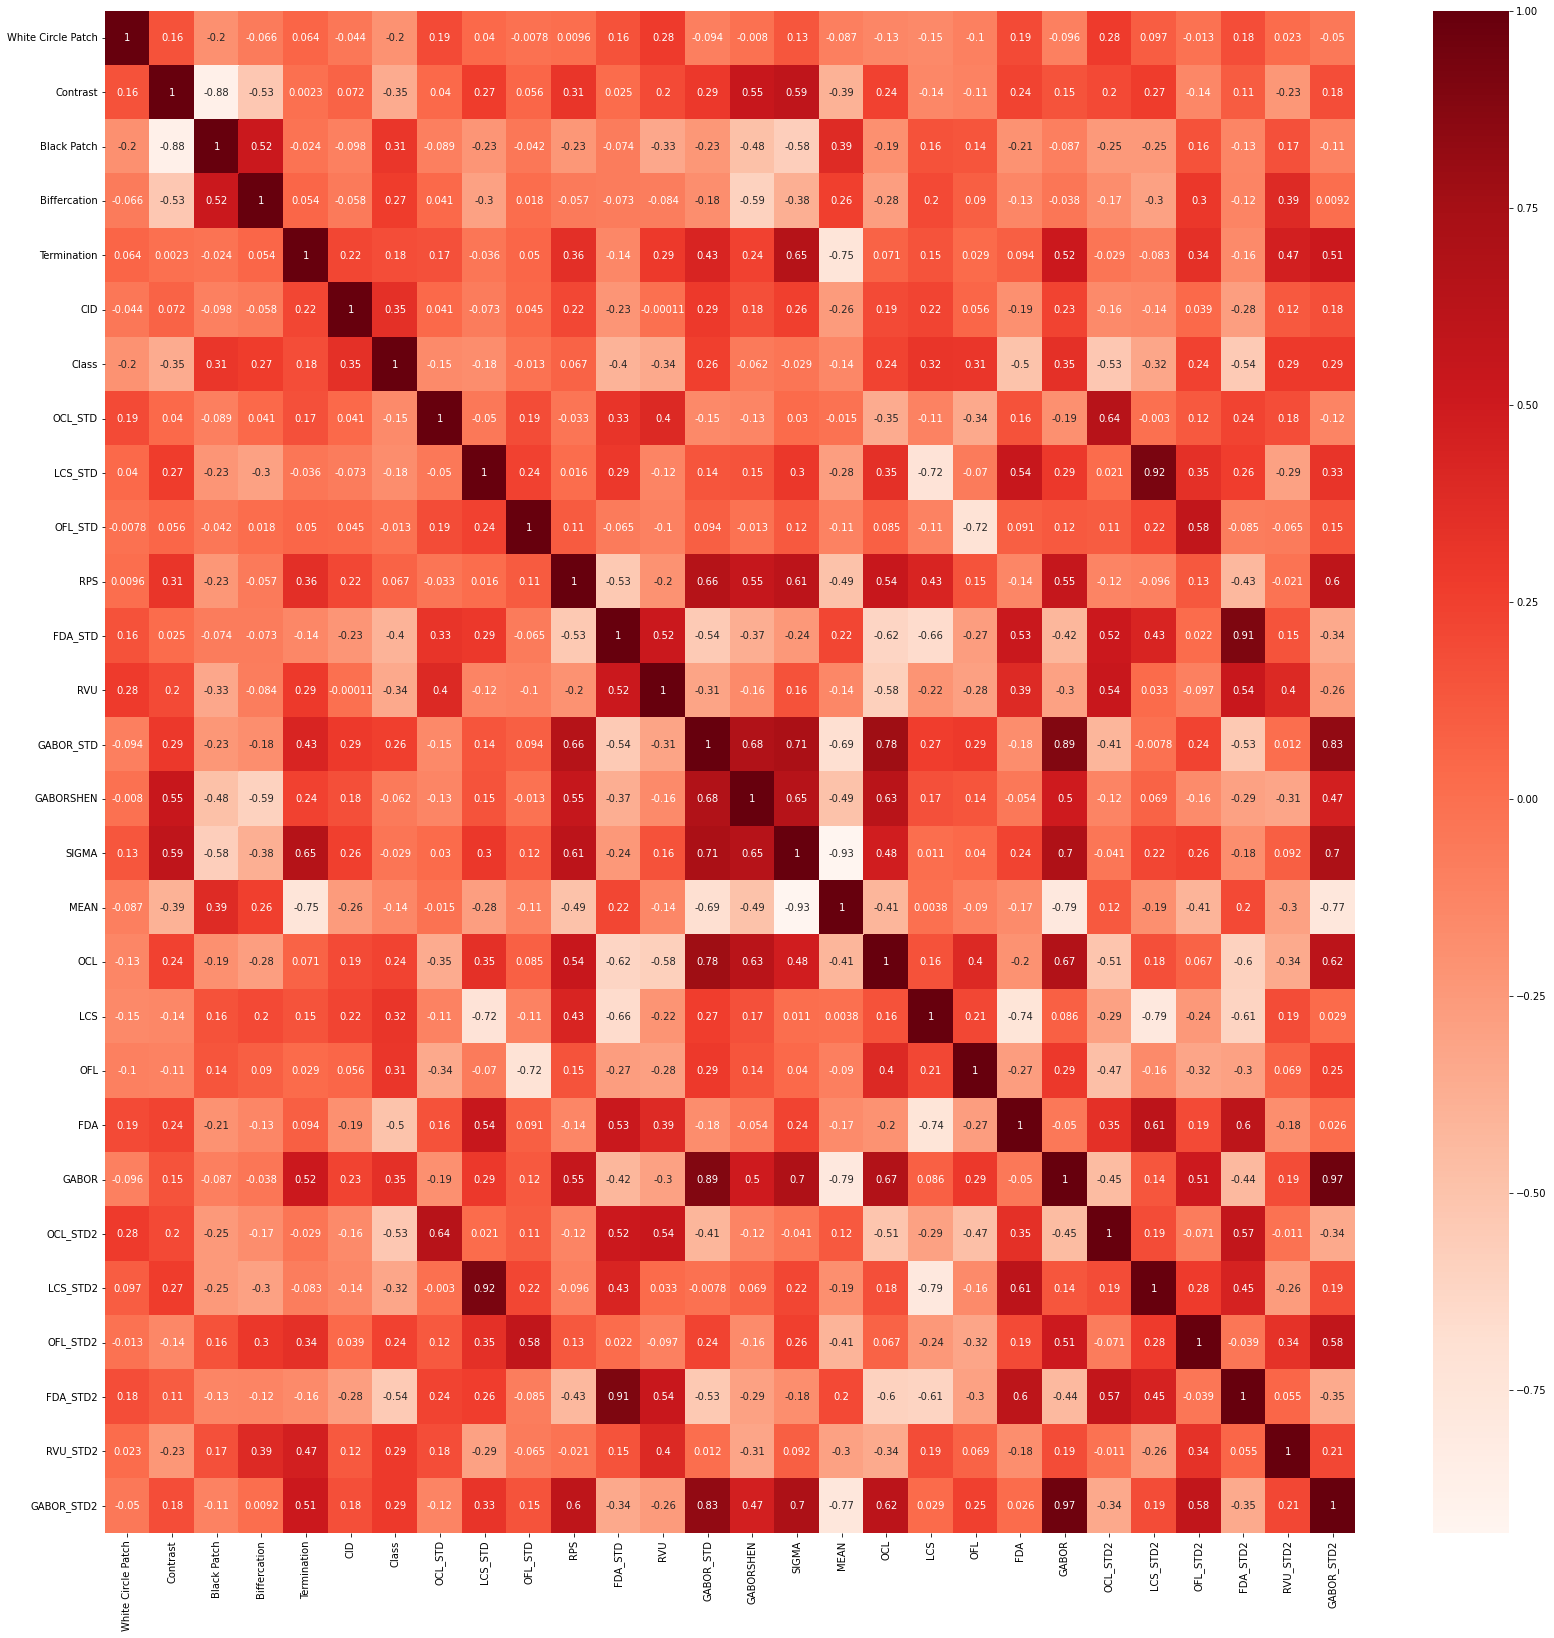

In [298]:
plt.figure(figsize=(28,28))
cor = train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [299]:
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>=0.4]
relevant_features

Class       1.000000
FDA         0.498432
OCL_STD2    0.529717
FDA_STD2    0.541019
Name: Class, dtype: float64

In [300]:
#83%,89%
#train = train[['White Circle Patch','Contrast','Black Patch','Biffercation','CID','Class','FDA_STD','RVU','GABOR_STD','OCL','LCS','OFL','FDA','GABOR','OCL_STD2','LCS_STD2','OFL_STD2','FDA_STD2','RVU_STD2','GABOR_STD2']].copy() #>=0.2,85%,80%
#train = train[['Contrast','Black Patch','CID','Class','FDA_STD','RVU','LCS','OFL','FDA','GABOR','OCL_STD2','LCS_STD2','FDA_STD2']].copy() #>=0.3,89%,82%
#train = train[['Contrast','Class','FDA_STD','FDA','OCL_STD2','FDA_STD2']].copy() #>=0.35,91%,84%
#train = train[['Class','FDA','OCL_STD2','FDA_STD2']].copy() #>=0.4,87%, 82%

In [301]:
test = pd.read_csv('/content/drive/MyDrive/CSV/TestingHiScan.csv')

In [302]:
#test = test[['White Circle Patch','Contrast','Black Patch','Biffercation','CID','Class','FDA_STD','RVU','GABOR_STD','OCL','LCS','OFL','FDA','GABOR','OCL_STD2','LCS_STD2','OFL_STD2','FDA_STD2','RVU_STD2','GABOR_STD2']].copy() #>=0.2
#test = test[['Contrast','Black Patch','CID','Class','FDA_STD','RVU','LCS','OFL','FDA','GABOR','OCL_STD2','LCS_STD2','FDA_STD2']].copy() #>=0.3
#test = test[['Contrast','Class','FDA_STD','FDA','OCL_STD2','FDA_STD2']].copy() #>=0.35
#test = test[['Class','FDA','OCL_STD2','FDA_STD2']].copy() #>=0.4

In [303]:

if "Filename"  in train.columns:
    train.drop(["Filename"], axis = 1, inplace = True)
if "Filename"  in test.columns:
    test.drop(["Filename"], axis = 1, inplace = True)

In [304]:
target = 'Class'
if "Set"  in train.columns:
    train.drop(["Set"], axis = 1)
train["Set"] = np.random.choice(["train", "valid"], p =[.8, .2], size=(train.shape[0],))
#train["Set"] = "train"    
train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index

In [305]:
train["Set"]

0       train
1       train
2       train
3       train
4       train
        ...  
1994    train
1995    train
1996    train
1997    train
1998    train
Name: Set, Length: 1999, dtype: object

In [306]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Class 2
Set 2


In [307]:
categorical_columns

['Class', 'Set']

In [308]:
categorical_dims

{'Class': 2, 'Set': 2}

In [309]:
if "Set" in test.columns:
  test.drop(['Set'], axis = 1)
test["Set"] = "test"
test_indices = test[test.Set=="test"].index

In [310]:
nunique = test.nunique()
types = test.dtypes



for col in test.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, test[col].nunique())
        l_enc = LabelEncoder()
        test[col] = test[col].fillna("VV_likely")
        test[col] = l_enc.fit_transform(test[col].values)
    else:
        test.fillna(test.loc[test_indices, col].mean(), inplace=True)

Class 2
Set 1


In [311]:
train.loc[train[target]==0, target] = "classZero"
train.loc[train[target]==1, target] = "classOne"

In [312]:
test.loc[test[target]==0, target] = "classZero"
test.loc[test[target]==1, target] = "classOne"

In [313]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [314]:
cat_idxs

[]

In [315]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":1,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

clf = TabNetClassifier(**tabnet_params
                      )

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [316]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]


In [317]:
X_test = test[features].values[test_indices]
y_test = test[target].values[test_indices]

In [318]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [319]:
class ClassificationSMOTE():
    """
    Apply SMOTE for classification tasks.
    This will average a percentage p of the elements in the batch with other elements.
    The target will stay unchanged and keep the value of the most important row in the mix.
    """
    def __init__(self, device_name="auto", p=0.8, alpha=0.5, beta=0.5, seed=0):
        ""
        self.seed = seed
        self._set_seed()
        self.device = define_device(device_name)
        self.alpha = alpha
        self.beta = beta
        self.p = p
        if (p < 0.) or (p > 1.0):
            raise ValueError("Value of p should be between 0. and 1.")

    def _set_seed(self):
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        return

    def __call__(self, X, y):
        batch_size = X.shape[0]
        random_values = torch.rand(batch_size, device=self.device)
        idx_to_change = random_values < self.p

        # ensure that first element to switch has probability > 0.5
        np_betas = np.random.beta(self.alpha, self.beta, batch_size) / 2 + 0.5
        random_betas = torch.from_numpy(np_betas).to(self.device).float()
        index_permute = torch.randperm(batch_size, device=self.device)

        X[idx_to_change] = random_betas[idx_to_change, None] * X[idx_to_change]
        X[idx_to_change] += (1 - random_betas[idx_to_change, None]) * X[index_permute][idx_to_change].view(X[idx_to_change].size())  # noqa

        return X, y

In [320]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [321]:
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug,#aug, None
    )
    save_history.append(clf.history["valid_auc"])

epoch 0  | loss: 0.70697 | train_auc: 0.48868 | valid_auc: 0.4892  |  0:00:00s
epoch 1  | loss: 0.58617 | train_auc: 0.37661 | valid_auc: 0.39467 |  0:00:00s
epoch 2  | loss: 0.54039 | train_auc: 0.45759 | valid_auc: 0.4696  |  0:00:00s
epoch 3  | loss: 0.47839 | train_auc: 0.49702 | valid_auc: 0.44368 |  0:00:00s
epoch 4  | loss: 0.44257 | train_auc: 0.48495 | valid_auc: 0.47435 |  0:00:00s
epoch 5  | loss: 0.37863 | train_auc: 0.60954 | valid_auc: 0.66213 |  0:00:00s
epoch 6  | loss: 0.34702 | train_auc: 0.62229 | valid_auc: 0.63729 |  0:00:00s
epoch 7  | loss: 0.30619 | train_auc: 0.62515 | valid_auc: 0.6253  |  0:00:01s
epoch 8  | loss: 0.30615 | train_auc: 0.61701 | valid_auc: 0.64483 |  0:00:01s
epoch 9  | loss: 0.26273 | train_auc: 0.62178 | valid_auc: 0.67768 |  0:00:01s
epoch 10 | loss: 0.27165 | train_auc: 0.63707 | valid_auc: 0.67281 |  0:00:01s
epoch 11 | loss: 0.2535  | train_auc: 0.69915 | valid_auc: 0.70885 |  0:00:01s
epoch 12 | loss: 0.23915 | train_auc: 0.72226 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.70697 | train_auc: 0.48868 | valid_auc: 0.4892  |  0:00:00s
epoch 1  | loss: 0.58617 | train_auc: 0.37661 | valid_auc: 0.39467 |  0:00:00s
epoch 2  | loss: 0.54039 | train_auc: 0.45759 | valid_auc: 0.4696  |  0:00:00s
epoch 3  | loss: 0.47839 | train_auc: 0.49702 | valid_auc: 0.44368 |  0:00:00s
epoch 4  | loss: 0.44257 | train_auc: 0.48495 | valid_auc: 0.47435 |  0:00:01s
epoch 5  | loss: 0.37863 | train_auc: 0.60954 | valid_auc: 0.66213 |  0:00:01s
epoch 6  | loss: 0.34702 | train_auc: 0.62229 | valid_auc: 0.63729 |  0:00:01s
epoch 7  | loss: 0.30619 | train_auc: 0.62515 | valid_auc: 0.6253  |  0:00:02s
epoch 8  | loss: 0.30615 | train_auc: 0.61701 | valid_auc: 0.64483 |  0:00:02s
epoch 9  | loss: 0.26273 | train_auc: 0.62178 | valid_auc: 0.67768 |  0:00:02s
epoch 10 | loss: 0.27165 | train_auc: 0.63707 | valid_auc: 0.67281 |  0:00:03s
epoch 11 | loss: 0.2535  | train_auc: 0.69915 | valid_auc: 0.70885 |  0:00:03s
epoch 12 | loss: 0.23915 | train_auc: 0.72226 | vali

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


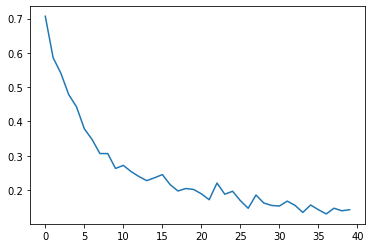

In [322]:
plt.plot(clf.history['loss'])

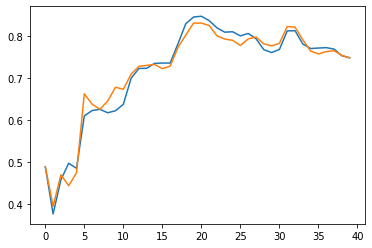

In [323]:
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

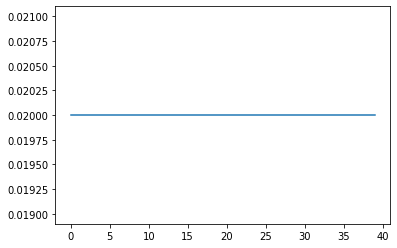

In [324]:
plt.plot(clf.history['lr'])

In [325]:
target = 'Class'

In [326]:
features

['White Circle Patch',
 'Contrast',
 'Black Patch',
 'Biffercation',
 'Termination',
 'CID',
 'OCL_STD',
 'LCS_STD',
 'OFL_STD',
 'RPS',
 'FDA_STD',
 'RVU',
 'GABOR_STD',
 'GABORSHEN',
 'SIGMA',
 'MEAN',
 'OCL',
 'LCS',
 'OFL',
 'FDA',
 'GABOR',
 'OCL_STD2',
 'LCS_STD2',
 'OFL_STD2',
 'FDA_STD2',
 'RVU_STD2',
 'GABOR_STD2']

In [327]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.830103995621237
FINAL TEST SCORE : 0.8920126666666667


In [328]:
clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classOne',
       'classOne'], dtype='<U9')

In [329]:
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [330]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [331]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE  : {loaded_test_auc}")

FINAL TEST SCORE  : 0.8920126666666667


In [332]:
assert(test_auc == loaded_test_auc)

In [333]:
loaded_clf.predict(X_test)

array(['classOne', 'classOne', 'classOne', ..., 'classZero', 'classOne',
       'classOne'], dtype='<U9')

In [334]:
clf.feature_importances_

array([0.02351307, 0.15184813, 0.00310452, 0.00657222, 0.04358962,
       0.05099686, 0.00090881, 0.1050509 , 0.00191158, 0.02720467,
       0.0492066 , 0.06561954, 0.00056431, 0.00022202, 0.0059101 ,
       0.04894162, 0.00023577, 0.00036842, 0.02446132, 0.12602114,
       0.05134389, 0.06174223, 0.00707718, 0.08107002, 0.02773465,
       0.0242853 , 0.01049551])

In [335]:
explain_matrix, masks = clf.explain(X_test)

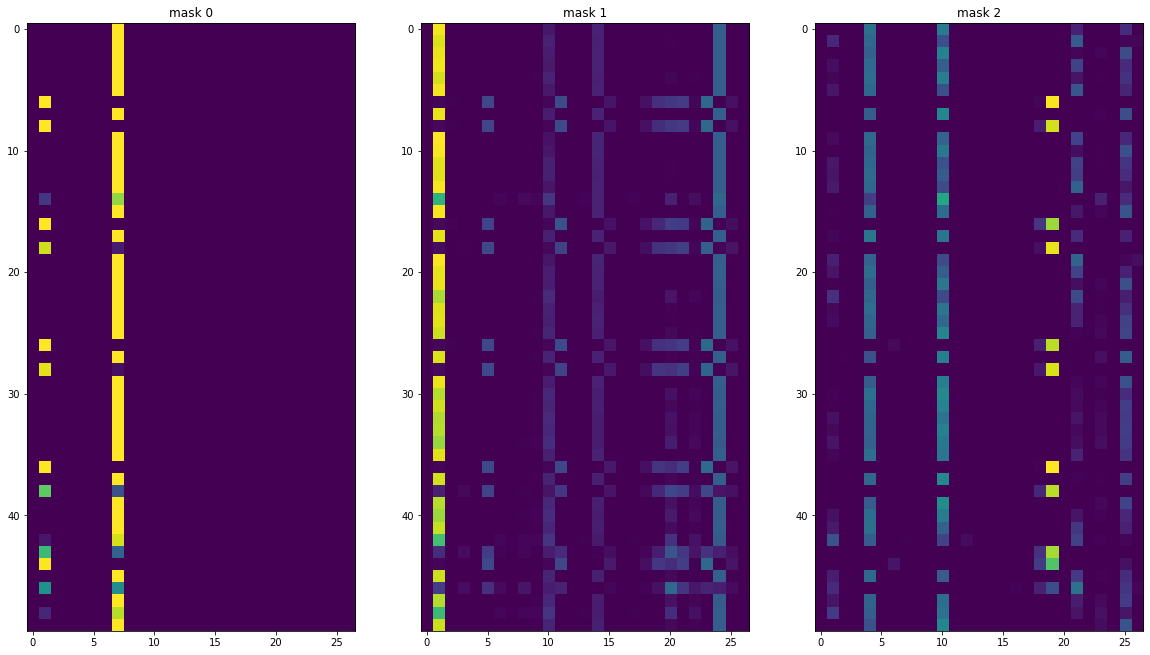

In [336]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")